# Ejercicios semana 8 - Clasificación

El objetivo de los ejercicios de esta semana es integrar lo que aprendimos de modelos para clasificación al flujo de trabajo que venimos desarrollando: separación de conjunto de entrenamiento y testeo; preparación de los datos; diseño de características (polinomiales); determinación de hiperparámetros a partir de validación cruzada; evaluación final con el conjunto de testeo.

## Funciones útiles

Volvemos a definir las funciones que usamos para los notebooks de esta semana.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def plot_clasi(x, t, ws, labels=[], xp=[-1,1], spines='zero',
               equal=True, join_centers=False, margin=None, **kwargs):
    """
    Plot results of linear classification problems.
    :param np.array x: Data matrix
    :param np.array t: Label vector.
    :param list or tuple ws: list with fitted paramter vector of models, one element per model
    :param tuple xp: start and end x-coordinates of decision boundaries and
                     margins.
    :param str or None spines: whether the spines go through zero. If None,
                               the default behaviour is used.
    :param bool equal: whether to use equal axis aspect (default=True;
                       recomended to see the parameter vector normal to
                       boundary)
    :param bool join_centers: whether to draw lines between classes centres.
    :param None or tuple margin: tupler of booleans that define whether
                                 to plot margin for each model being plotted.
                                 If None, False for all models.
    """
    assert len(labels) == len(ws) or len(labels) == 0

    if margin is None:
        margin = [False] * len(ws)
    else:
        margin = np.atleast_1d(margin)
    assert len(margin) == len(ws)

    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')

    # Agregemos el vector al plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111)

    xc1 = x[t == np.unique(t).max()]
    xc2 = x[t == np.unique(t).min()]

    ax.plot(*xc1.T, 'or', mfc='None', label='C1')
    ax.plot(*xc2.T, 'ob', mfc='None', label='C2')

    for i, w in enumerate(ws):
        # Separa el sesgo del resto de los pesos
        thr = -w[0]
        w = w[1:]
        # Calcula la norma del vector
        wnorm = np.sqrt(np.sum(w**2))

        # Ploteo vector de pesos
        ax.quiver(0, thr/w[1], w[0]/wnorm, w[1]/wnorm,
                  color='C{}'.format(i+2), scale=10, label=labels[i],
                  zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr - w[0]*xp)/w[1]

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))

        # ploteo el margen (para SVC)
        if margin[i]:
            for marg in [-1, 1]:
                ym = yp + marg/w[1]
                plt.plot(xp, ym, ':', color='C{}'.format(i+2))

    if join_centers:
        # Ploteo línea que une centros de los conjuntos
        mu1 = xc1.mean(axis=1)
        mu2 = xc2.mean(axis=1)
        ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)

    ax.legend(loc=0, fontsize=12)
    if equal:
        ax.set_aspect('equal')

    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)

    for k in kwargs:
        print(k, kwargs[k])
        getattr(ax, 'set_'+k)(kwargs[k])

    return

def plot_fundec(fitter, x, t):

    plt.figure(figsize=(9, 7))

    xx, yy = np.meshgrid(np.linspace(x[:, 0].min()-1, x[:, 0].max()+1, 200),
                            np.linspace(x[:, 1].min()-1, x[:, 1].max()+1, 200))

    # evaluate decision function
    try:
        Z = fitter.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        vcenter = 0.5
        name = 'Probabilidad'
    except AttributeError:
        Z = fitter.decision_function(np.c_[xx.ravel(), yy.ravel()])
        vcenter = 0.0
        name = 'Función de decisión'
    Z = Z.reshape(xx.shape)

    # veamos la función de decisión y la frontera de decisión
    mynorm = colors.TwoSlopeNorm(vmin=Z.min(), vmax=Z.max(), vcenter=vcenter)
    pme = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.RdBu_r, norm=mynorm, shading='auto')
    plt.colorbar(label= name)

    plt.contour(xx, yy, Z, [vcenter,], colors='0.5', zorder=1)
    if name == 'Probabilidad':
        plt.contour(xx, yy, Z, [vcenter - 0.45, vcenter + 0.45],
                    colors='white', linestyles='dashed', zorder=1)

    xc1 = x[t == np.unique(t.flatten()).max()]
    xc2 = x[t == np.unique(t.flatten()).min()]

    plt.plot(*xc1.T, 'or', mfc='None', label='C1')
    plt.plot(*xc2.T, 'ob', mfc='None', label='C2')

    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

    return pme

## Café con dos medialunas

Vamos a trabajar con un conjunto de datos sintéticos que puede armarse con la función de `sklearn` llamada `make_moons`.

Vamos a generar el dataset y visualizarlo.

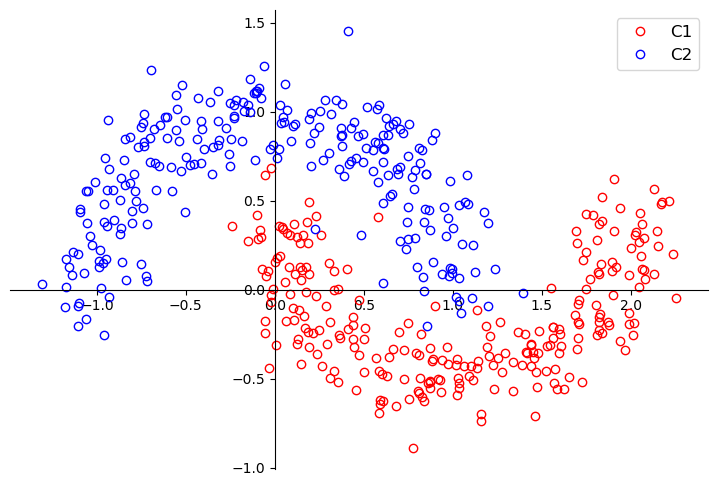

In [59]:
from sklearn.datasets import make_moons

datos, t = make_moons(n_samples=500, noise=0.15, random_state=20230628)
plot_clasi(datos, t, ws=[])

Este conjunto tiene dos variables $(x_1, x_2)$, que están contenidas en la varible `datos` que recién definimos. Además, el conjunto está etiquetado (rojo o azul; 0 o 1), y el valor de la etiqueta está contenido en la variable `t` (de *target*). 

Como se pueden imaginar, este conjunto no es linealmente separable si usamos estas dos variables separar con un modelo lineal, pero podemos generar nuevas características a partir de estas con `PolynomialFeatures` e intentar separar el conjunto.

Pero antes de eso vamos a separar el conjunto.

## Ejercicio 1

  - Separen al conjunto de datos original (`datos`) en un conjunto de entrenamiento (80%) y otro de testeo (20%). Agreguen al nombre de las variables `_train` y `_test` para diferenciarlas. 

**Sugerencia**: verifiquen que los arreglos resultantes tienen el tamaño y forma que esperan mirando el atributo `shape`

In [60]:
from sklearn import model_selection as ms

datos_train, datos_test, t_train, t_test =ms.train_test_split(datos, t, test_size=0.2)

Ahora empiezan las decisiones. Elijan un algoritmo (Perceptrón o Regresión Logística) y un tipo de penalización (L1 o L2) con el que vamos a trabajar en esta primera parte.


## Ejercicio 2
 
Preparen un pipeline que estandarice los datos, genere features polinomiales de algún grado (empecemos con `degree=2`) y los use para ajustar el modelo elegido con una dada constante de regularización.

**Ayuda**: recuerden que para armar el pipeline, hay que dar una lista (es decir, `[ ... ]`) de tuplas (es decir `( ... )`) con el nombre de los pasos y la función o clase correspondiente.

**Ayuda2**: recuerden que cuando se combina con features polinomiales hay que setear `fit_intercept=False` en el clasificador (a menos que usen `include_bias=False` en `PolynomialFeatures`).

In [61]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Perceptron

mi_pipe = Pipeline([('estandariza', StandardScaler()),
                    ('poly', PolynomialFeatures(degree=3)),
                    ('clasi', LogisticRegression(fit_intercept=False,
                                                 penalty='l2',
                                                 C=1.0))])

## Ejercicio 3

Ajusten los parámetros del clasificador usando el pipeline del paso anterior con el conjunto de entrenamiento.

In [62]:
mi_pipe.fit(datos_train, t_train)

Pipeline(steps=[('estandariza', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3)),
                ('clasi', LogisticRegression(fit_intercept=False))])

## Ejercicio 4

Impriman en pantalla los coeficientes encontrados. Recuerden que pueden acceder a cada paso del pipeline como si fuera un diccionario de python. P.ej., si llamé `'clasi'` al último paso, puedo usar `mi_pipe['clasi']` para acceder al clasificador.

Respondan: ¿cuántos coeficientes hay? ¿tiene sentido con la cantidad de grados elegido para el PolynomialFeatures?

In [63]:
mi_pipe['clasi'].coef_

array([[-0.18850093, -3.72922594, -1.50555099, -0.02323549,  0.44943475,
        -0.14427745,  2.87267428, -0.41050992,  0.2556285 , -2.03190696]])

## Ejercicio 5

Usen la función `plot_fundec` para ver la frontera de decisión. 
    
Evalúen si el grado del polinomio es el adecuado. Si no, súbanlo o bájenlo hasta encontrar algo que a ojo les resulte que funciona.

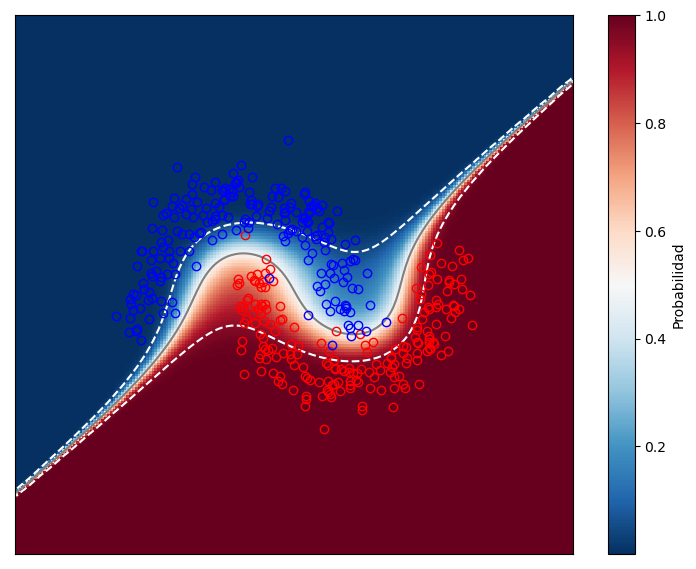

In [64]:
plot_fundec(mi_pipe, datos_train, t_train)

## Ejercicio 6

Evalúen el desempeño del algoritmo en base a sus métricas de exactitud, precisión y exhaustividad. También calculen la matriz de pérdida (todo en el conjunto de entrenamiento).

In [65]:
from sklearn import metrics as m

probas = mi_pipe.predict_proba(datos_train)

umbrales = [0.5,]

for umbral in umbrales:
    y1 = np.where(probas[:, 1] >= umbral, 1, 0)

    print('Umbral {}'.format(umbral))
    print('----')
    print('Exactitud: {:.3f}'.format(m.accuracy_score(t_train, y1)))
    print('Precisión: {:.3f}'.format(m.precision_score(t_train, y1)))
    print('Exhaustividad: {:.3f}'.format(m.recall_score(t_train, y1)))
    print('f1 score: {:.3f}'.format(m.f1_score(t_train, y1)))
    print('####')

    print('Matriz de confusión')
    print(m.confusion_matrix(t_train, y1))



Umbral 0.5
----
Exactitud: 0.983
Precisión: 0.974
Exhaustividad: 0.990
f1 score: 0.982
####
Matriz de confusión
[[203   5]
 [  2 190]]


## Ejercicio 7 

Usar `GridSearchCV` para buscar valores óptimos de los hiperparámetros: grado de la transformación polinomial (`degree`) y constante de regularización (`C` o `alpha`, según qué modelo hayan elegido). ¿Cuáles son los mejores parámetros?

**Recordatorio**. Cuando se usa `GridSearchCV` con un pipeline, el nombre de los parámetros hay que escribirlos como 'NOMBREDELPASO__NOMBREDELPARAMETRO'. Por ejemplo, para el paso de transformación polinomial, el grado es `poly__degree`.

In [67]:
from sklearn.model_selection import GridSearchCV

mi_grilla =GridSearchCV(mi_pipe,
                        param_grid = {'poly__degree': [3, 4, 5, 6, 7],
                                      'clasi__C': np.logspace(0, 3, 10)},
                        cv=5, scoring='neg_log_loss', n_jobs=-1)

In [68]:
mi_grilla.fit(datos_train, t_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tf-mac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/tf-mac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estandariza', StandardScaler()),
                                       ('poly', PolynomialFeatures(degree=3)),
                                       ('clasi',
                                        LogisticRegression(fit_intercept=False))]),
             n_jobs=-1,
             param_grid={'clasi__C': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ]),
                         'poly__degree': [3, 4, 5, 6, 7]},
             scoring='neg_log_loss')

In [69]:
mi_grilla.best_params_

{'clasi__C': 21.544346900318832, 'poly__degree': 3}

## Ejercicio 8

Usar `plot_fundec` con el mejor estimador obtenido a partir de la búsqueda. Calcular las métricas de arriba, pero esta vez usando `cross_val_predict` para obtener las predicciones del modelo.

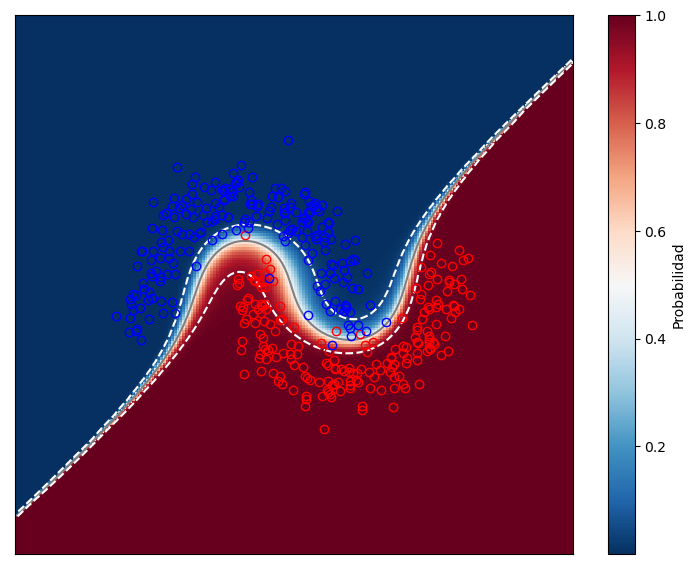

In [70]:
plot_fundec(mi_grilla.best_estimator_, datos_train, t_train)

In [71]:
from sklearn.model_selection import cross_val_predict

mejor_estimador = mi_grilla.best_estimator_

y1 = cross_val_predict(mejor_estimador, datos_train, t_train)

umbrales = [0.5,]

for umbral in umbrales:

    print('Umbral {}'.format(umbral))
    print('----')
    print('Exactitud: {:.3f}'.format(m.accuracy_score(t_train, y1)))
    print('Precisión: {:.3f}'.format(m.precision_score(t_train, y1)))
    print('Exhaustividad: {:.3f}'.format(m.recall_score(t_train, y1)))
    print('f1 score: {:.3f}'.format(m.f1_score(t_train, y1)))
    print('####')

    print('Matriz de confusión')
    print(m.confusion_matrix(t_train, y1))

Umbral 0.5
----
Exactitud: 0.985
Precisión: 0.984
Exhaustividad: 0.984
f1 score: 0.984
####
Matriz de confusión
[[205   3]
 [  3 189]]


## Ejercicio 9

Evalúen ahora el algoritmo tuneado en el conjunto de testeo. Comparen con los resultados del ejericio anterior.

In [72]:
mejor_estimador = mi_grilla.best_estimator_

y1 = mejor_estimador.predict(datos_test)

umbrales = [0.5,]

for umbral in umbrales:

    print('Umbral {}'.format(umbral))
    print('----')
    print('Exactitud: {:.3f}'.format(m.accuracy_score(t_test, y1)))
    print('Precisión: {:.3f}'.format(m.precision_score(t_test, y1)))
    print('Exhaustividad: {:.3f}'.format(m.recall_score(t_test, y1)))
    print('f1 score: {:.3f}'.format(m.f1_score(t_test, y1)))
    print('####')

    print('Matriz de confusión')
    print(m.confusion_matrix(t_test, y1))

Umbral 0.5
----
Exactitud: 0.980
Precisión: 1.000
Exhaustividad: 0.966
f1 score: 0.982
####
Matriz de confusión
[[42  0]
 [ 2 56]]


## Mismo con el perceptron

In [73]:
mi_pipe_perce = Pipeline([('estandariza', StandardScaler()),
                       ('poly', PolynomialFeatures(degree=3)),
                        ('clasi', Perceptron(fit_intercept=False,
                                                     penalty='l2',
                                                     alpha=1.0))])

mi_grilla_perce =GridSearchCV(mi_pipe_perce,
                              param_grid = {'poly__degree': [3, 4, 5, 6, 7],
                                            'clasi__alpha': np.logspace(-3, 0, 10)},
                              cv=5, n_jobs=-1)

In [74]:
mi_grilla_perce.fit(datos_train, t_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estandariza', StandardScaler()),
                                       ('poly', PolynomialFeatures(degree=3)),
                                       ('clasi',
                                        Perceptron(alpha=1.0,
                                                   fit_intercept=False,
                                                   penalty='l2'))]),
             n_jobs=-1,
             param_grid={'clasi__alpha': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                         'poly__degree': [3, 4, 5, 6, 7]})

In [78]:
mi_grilla_perce.best_params_

{'clasi__alpha': 0.001, 'poly__degree': 7}

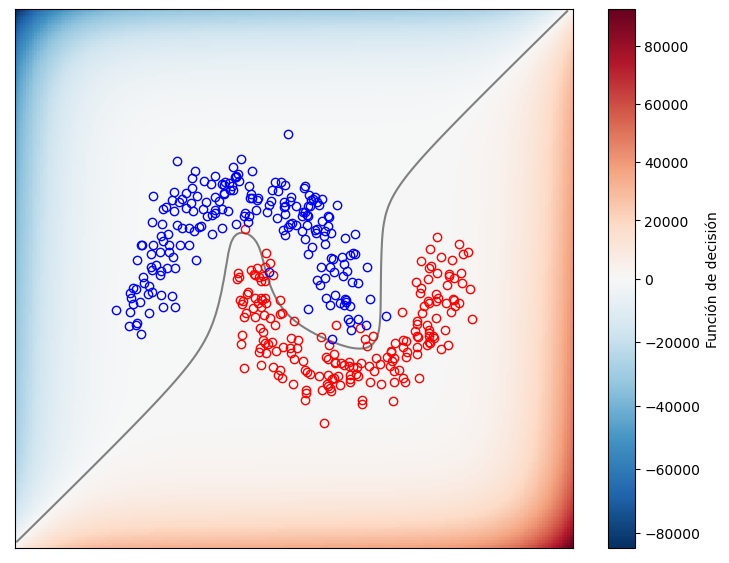

In [75]:
plot_fundec(mi_grilla_perce.best_estimator_, datos_train, t_train)

In [76]:
mejor_estimador = mi_grilla_perce.best_estimator_

y1 = cross_val_predict(mejor_estimador, datos_train, t_train)

umbrales = [0.5,]

for umbral in umbrales:

    print('Umbral {}'.format(umbral))
    print('----')
    print('Exactitud: {:.3f}'.format(m.accuracy_score(t_train, y1)))
    print('Precisión: {:.3f}'.format(m.precision_score(t_train, y1)))
    print('Exhaustividad: {:.3f}'.format(m.recall_score(t_train, y1)))
    print('f1 score: {:.3f}'.format(m.f1_score(t_train, y1)))
    print('####')

    print('Matriz de confusión')
    print(m.confusion_matrix(t_train, y1))

Umbral 0.5
----
Exactitud: 0.970
Precisión: 0.950
Exhaustividad: 0.990
f1 score: 0.969
####
Matriz de confusión
[[198  10]
 [  2 190]]
